In [1]:
import pandas as pd
import git
from pathlib import Path
import numpy as np
from tqdm import tqdm
from sklearn.metrics import pairwise_distances
from pynndescent import NNDescent
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from typing import List
from pykanto.utils.paths import (
    ProjDirs,
    get_file_paths,
    get_wavs_w_annotation,
    link_project_data,
)
from collections import Counter
import seaborn as sns
from sklearn.neighbors import BallTree
from pykanto.utils.compute import with_pbar

# Project setup

In [2]:
PROJECT_ROOT = Path(
    git.Repo(".", search_parent_directories=True).working_tree_dir
)
DATASET_ID = "GRETI_2021-22"

data_path = PROJECT_ROOT / "data" / "datasets" / DATASET_ID / "ML"
train_path, test_path = data_path / "train", data_path / "test"
vector_dir = (
    PROJECT_ROOT
    / "data"
    / "datasets"
    / DATASET_ID
    / "ML"
    / "output"
    / "feat_vectors.csv"
)

In [3]:
DATA_LOCATION = Path("/data/zool-songbird/shil5293/data/wytham-great-tit")
link_project_data(DATA_LOCATION, PROJECT_ROOT / "data")

segmented_dir = PROJECT_ROOT / "data" / "segmented" / DATASET_ID.lower()[:-3]
DIRS = ProjDirs(PROJECT_ROOT, segmented_dir, DATASET_ID, mkdir=True)

/data/zool-songbird/shil5293/projects/pykanto/pykanto/utils/paths.py:374: UserWarning: link_project_data() failed: the destination directory is not empty.
  warnings.warn(


# Data ingest

## Breeding data

In [4]:
# Read in bird breeding data
fs = [
    DIRS.RESOURCES / "bird_data" / f"bird_data_{year}.csv"
    for year in ["2020", "2021"]
]
bird_data = pd.concat([pd.read_csv(f, index_col=0) for f in fs])

# Prepare spatial information

coord_df = bird_data[["x", "y"]].copy()
coord_df["xy"] = coord_df[["x", "y"]].values.tolist()
coord_df = pd.DataFrame(coord_df["xy"], index=bird_data.index, columns=["xy"])

## Feature vectors

In [5]:
# Read in feature vectors
feat_vec = pd.read_csv(vector_dir, index_col=0)

# Remove broken bird (20211O115; something physically wrong with the poor thing)
feat_vec = feat_vec[~feat_vec.index.str.contains("20211O115")]

# Get labels
imgpaths = [i for i in train_path.glob("*/*.jpg")]
fnames = np.unique(feat_vec.index.values)
labels = []
for fname in tqdm(fnames, total=len(fnames)):
    for p in imgpaths:
        if fname == p.stem:
            labels.append(p.parent.name)

# change second breeding attempts to first - but need to fix bug properly
# see TODO in 'ling-songs-to-records'
labels = np.array([f"{l[:4]}1{l[5:]}" if l[4] == "2" else l for l in labels])

# Add labels and calculate class means
feat_vec.index = labels
vecdf = feat_vec.groupby(feat_vec.index).mean()
vecmed = vecdf.to_numpy()

# Get all class labels
labs = vecdf.index.values

# Add repertoire size column to bird data
pnums = [l.split("_")[0] for l in labs]
bird_data["repertoire_size"] = pd.Series(Counter(pnums))

# How many birds are in >1yr?
allrings = bird_data.query(
    "father == father and repertoire_size == repertoire_size"
).father.tolist()
print(f"{len(allrings) - len(set(allrings)) } were recorded in both years")

100%|██████████████████████████████████████| 5264/5264 [00:16<00:00, 321.21it/s]


21 were recorded in both years


# Derive distances 

## NN for every class*bird

In [6]:
metric = "cosine"

# calculate pairwise distances
sim_mat = pairwise_distances(vecmed, metric=metric)
mx = 1 - sim_mat
mx = np.round((mx - np.min(mx)) / np.ptp(mx), 5)

# Calculate nn index
nnindex = NNDescent(mx, metric=metric)

# nn queries
indx, dists = nnindex.query(mx, k=6)
indx = indx[:, 1:]
dists = dists[:, 1:]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Discrete sharing matrices (by year)

### With kn-spatial-n

In [11]:
# Build discrete song sharing matrix (by year)
years = ["2020", "2021"]
ac_knn = 7
sp_knn = 5

knn_sharing = []
for year in years:
    # Add labels and calculate class means
    metric = "cosine"
    feat_df = vecdf[vecdf.index.str.contains(year)]
    labs = feat_df.index.values

    # calculate pairwise distances
    sim_mat = pairwise_distances(feat_df.to_numpy(), metric=metric)
    mx = 1 - sim_mat
    mx = np.round((mx - np.min(mx)) / np.ptp(mx), 5)
    nnindex = NNDescent(mx, metric=metric)
    indx, dists = nnindex.query(mx, k=ac_knn + 1)
    indx = indx[:, 1:]
    dists = dists[:, 1:]

    wl = len(mx)
    m = np.zeros(shape=(wl, wl))
    for query in with_pbar(feat_df.index):
        i = np.where(labs == query)[0][0]
        ds, ne = dists[i], labs[indx[i]]
        m[i, np.in1d(feat_df.index, ne).nonzero()[0]] = 1

    # pd.DataFrame(m, index=feat_df.index, columns=feat_df.index)

    # get nearest spatial neighbours
    coordata = bird_data.query(
        f"year=={int(year)} and repertoire_size == repertoire_size"
    )[["x", "y"]]
    tree = BallTree(coordata.values, metric="euclidean")
    distances, indices = tree.query(coordata.values, k=sp_knn + 1)
    coordata["spatial_nn"] = [coordata.index[i].values[1:] for i in indices]

    # Calculate sharing with nearest spatial neighbours

    labs_dict = {
        pnum: [l for l in labs if pnum == l.split("_")[0]]
        for pnum in coordata.index
    }

    nn_sharing = []
    for pnum1 in tqdm(coordata.index):
        rep1 = labs_dict[pnum1]
        idx1 = [np.where(labs == i)[0][0] for i in rep1]
        for pnum2 in coordata.loc[pnum1, "spatial_nn"]:
            rep2 = labs_dict[pnum2]
            idx2 = [np.where(labs == i)[0][0] for i in rep2]
            shared = m[np.ix_(idx1, idx2)]
            # if np.sum(shared) > 1:
            #     print(pd.DataFrame(shared, index=rep1, columns=rep2))
            nn_sharing.append(
                [pnum1, pnum2, 2*int(np.sum(shared)), len(rep1) + len(rep2)]
            ) # to calculate Song Sharing Index (McGregor and Krebs 1982)
            
    nn_sharing_df = pd.DataFrame(
        nn_sharing, columns=["bird1", "bird2", "shared", f"total_nn"]
    )
    nn_sharing_sum_df = nn_sharing_df.groupby(["bird1"]).sum()
    nn_sharing_sum_df.index.rename("pnum", inplace=True)
    nn_sharing_sum_df = nn_sharing_sum_df.reset_index(level=0)
    knn_sharing.append(nn_sharing_sum_df)


knn_sharing_df = pd.concat(knn_sharing)
bird_data_sharing = bird_data.merge(
    knn_sharing_df, left_on="pnum", right_on="pnum", how="outer"
)

bird_data_sharing.query(
    "father == father"
)

# 20211B108 is a good show bird

  0%|          | 0/287 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 116/116 [00:00<00:00, 4492.39it/s]


  0%|          | 0/465 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 156/156 [00:00<00:00, 3383.15it/s]


,pnum,april_lay_date,clutch_size,num_fledglings,father,mother,box,year,wytham_born,natal_box,age,x,y,recorded,repertoire_size,shared,total_nn
8,20201B161,15.0,9.0,8,te80930,tw77018,B161,2020,True,B8,5.0,447430.72,207645.76,True,1.0,2.0,16.0
17,20201B205,21.0,7.0,5,vz32583,ty70131,B205,2020,True,MP75,6.0,447877.72,207724.76,True,1.0,2.0,25.0
18,20201B207,22.0,4.0,3,ty70159,NaN,B207,2020,False,NaN,6.0,447530.72,207839.76,True,1.0,0.0,17.0
19,20201B221,19.0,9.0,0,vz33585,NaN,B221,2020,False,NaN,6.0,447557.72,207344.76,True,2.0,4.0,27.0
20,20201B225,15.0,8.0,0,vz30587,tx42888,B225,2020,False,NaN,5.0,447796.72,207941.76,True,2.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,20211W79,13.0,8.0,7,ty68197,ty68013,W79,2021,True,W21,5.0,445684.33,209242.71,True,4.0,10.0,40.0
536,20211W80,25.0,7.0,7,tr43333,ts47681,W80,2021,False,NaN,5.0,445704.33,209263.71,True,4.0,10.0,35.0
537,20211W81,19.0,9.0,7,vz33280,vn85374,W81,2021,False,NaN,6.0,445606.33,209304.71,True,6.0,6.0,47.0
539,20211W87,16.0,6.0,6,ty68090,ty68708,W87,2021,True,W29,5.0,445546.33,209292.71,True,3.0,2.0,34.0


In [ ]:
# TODO: get proportion of neighbours that are immigrant for each bird

bird_data_sharing.query(
    "father == father"
)

# get nearest spatial neighbours
coordata = bird_data.query(
    f"year=={int(year)} and repertoire_size == repertoire_size"
)[["x", "y"]]
tree = BallTree(coordata.values, metric="euclidean")
distances, indices = tree.query(coordata.values, k=sp_knn + 1)
coordata["spatial_nn"] = [coordata.index[i].values[1:] for i in indices]
    
    

# TODO: get mean dispersal distance for neighbourhood
for pnum in tqdm(coordata.index):
    bird_data.loc[coordata.loc[pnum, "spatial_nn"]]
    ...


In [15]:
# save these, both individual and summaries for each bird (shared/total)

# also make this for all birds, not only neighbours, and add spatial coordinates / distances

In [15]:
# Build pairwise distance dataframe for all classes
mat_df = pd.DataFrame(mx, index=vecdf.index, columns=vecdf.index)
tall_mat = (
    mat_df.stack()
    .reset_index()
    .rename(columns={"level_0": "class1", "level_1": "class2", 0: "dist"})
)
tall_mat = tall_mat.query("dist != 1")
tall_mat["bird1"] = tall_mat.class1.apply(lambda x: x.split("_")[0])
tall_mat["bird2"] = tall_mat.class2.apply(lambda x: x.split("_")[0])
tall_mat["year1"] = tall_mat.class1.apply(lambda x: x[:4])
tall_mat["year2"] = tall_mat.class2.apply(lambda x: x[:4])

100%|███████████████████████████████████████| 116/116 [00:00<00:00, 1570.29it/s]

              20201CP7_0  20201CP7_1  20201CP7_3  20201CP7_4
20201CP119_0         0.0         0.0         0.0         0.0
20201CP119_2         0.0         1.0         0.0         0.0
20201CP119_3         0.0         0.0         0.0         1.0
20201CP119_5         0.0         0.0         0.0         0.0
            20201CP12_0  20201CP12_1
20201CP3_0          1.0          1.0
20201CP3_1          0.0          0.0
            20201CP119_0  20201CP119_2  20201CP119_3  20201CP119_5
20201CP7_0           0.0           0.0           1.0           0.0
20201CP7_1           0.0           1.0           0.0           0.0
20201CP7_3           0.0           0.0           0.0           0.0
20201CP7_4           0.0           0.0           1.0           0.0
             20201MP42_0  20201MP42_1  20201MP42_2
20201MP41_0          0.0          1.0          0.0
20201MP41_1          0.0          0.0          1.0
20201MP41_4          0.0          0.0          0.0
             20201MP50_1
20201MP41_0         

# Plot query results

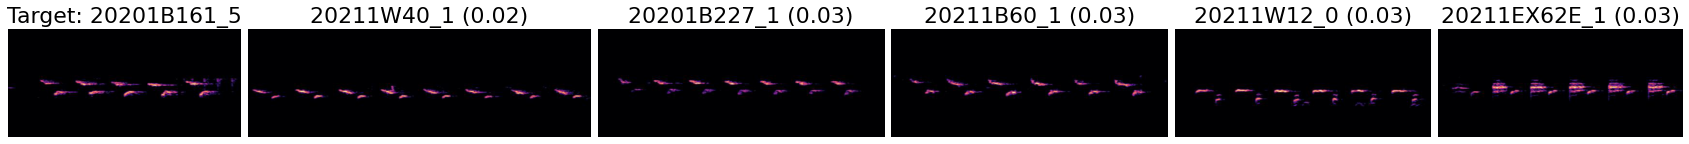

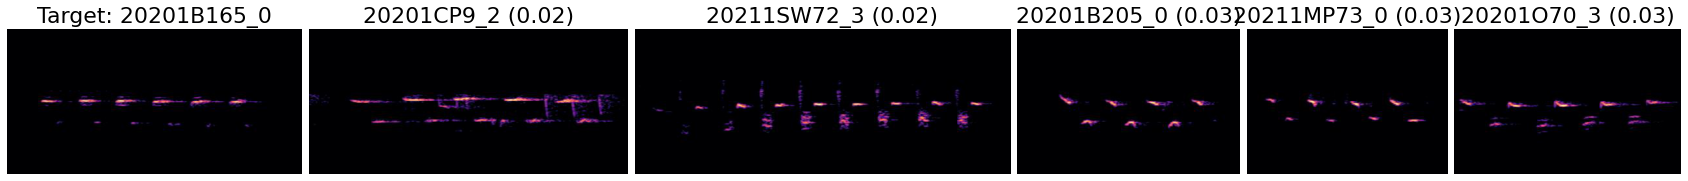

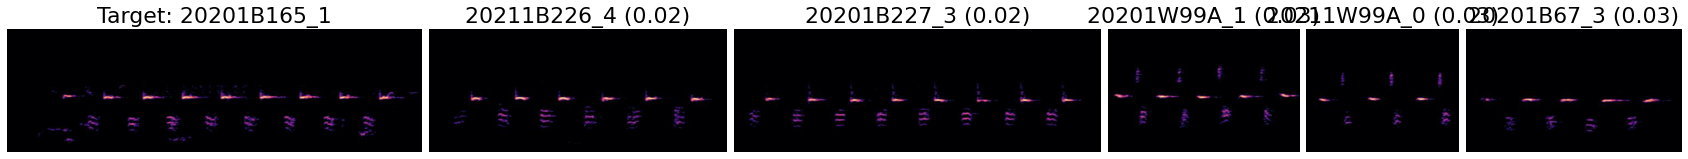

In [66]:
# Plot closest song types


def plot_knn(folder: List[Path], query, neighbours, distances):
    lab_folders = {p.stem: p for p in list(folder.glob("*"))}
    images = [list(lab_folders[query].glob("*.jpg"))[0]] + [
        list(lab_folders[l].glob("*.jpg"))[0] for l in neighbours
    ]
    fig = plt.figure(figsize=(30, 30))
    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=(1, len(images)),
        axes_pad=0.1,
    )

    for i, (ax, path) in enumerate(zip(grid, images)):
        # Iterating over the grid returns the Axes.
        name = path.parent.name
        if i == 0:
            ax.set_title(f"Target: {name}", fontsize=22)
        else:
            ax.set_title(f"{name} ({distances[i-1]:.2f})", fontsize=22)
        ax.imshow(Image.open(path))
        ax.axis("off")
    plt.show()


for query in labs[0:3]:
    # query = '20211W64A_2'
    loc = np.where(labs == query)[0][0]
    distances, neighbours = dists[loc], labs[indx[loc]]
    plot_knn(train_path, query, neighbours, distances)

# UMAP projection

In [13]:
# Umap of song type median positions
# from cuml import UMAP as cumlUMAP
from umap import UMAP

reducer = UMAP(
    n_neighbors=10, n_components=2, min_dist=0.3, metric="precomputed"
)
embedding = reducer.fit_transform(sim_mat)
allrings = bird_data.query(
    "father == father and repertoire_size == repertoire_size"
).father.tolist()
print(f"{len(allrings) - len(set(allrings)) } were recorded in both years")

/data/zool-songbird/shil5293/envs/pykanto-ml/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


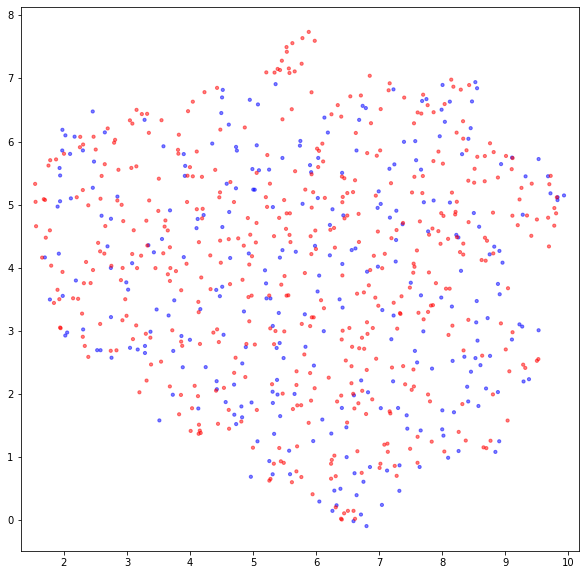

In [14]:
plt.figure(figsize=(10, 10))

colours = ["blue" if "2020" in lab else "red" for lab in labs]
plt.scatter(embedding[:, 0], embedding[:, 1], c=colours, s=10, alpha=0.5)
plt.gca().set_aspect("equal", "datalim")

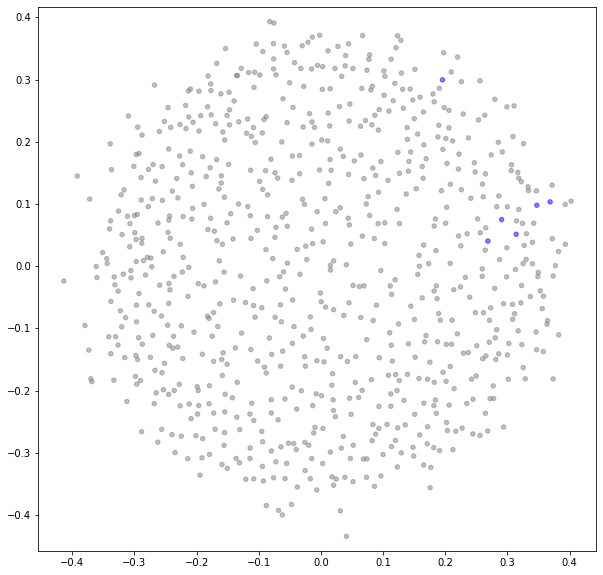

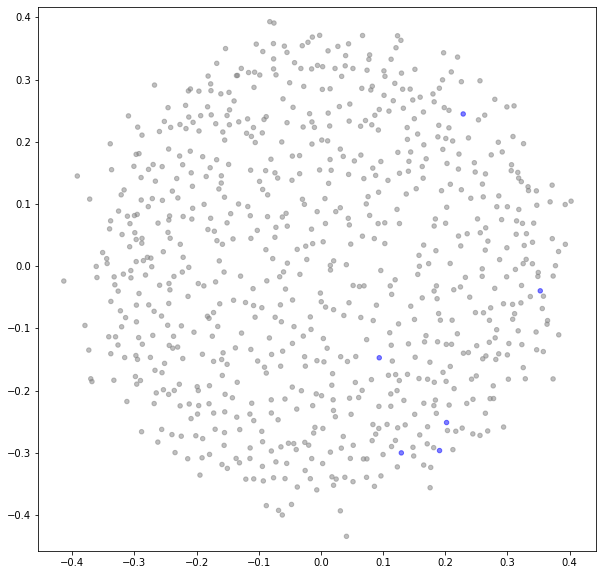

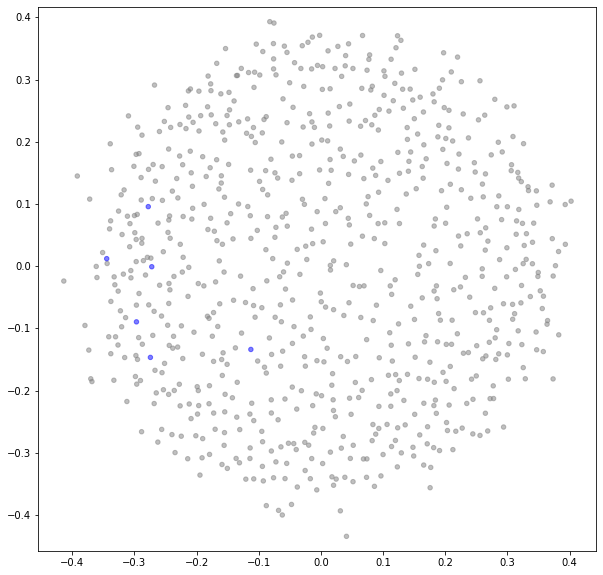

In [15]:
# MDS
from sklearn.manifold import MDS
import seaborn as sns

mds = MDS(
    metric=True,
    dissimilarity="precomputed",
    random_state=0,
    n_jobs=-1,
    verbose=1,
)
# Get the embeddings
pts = mds.fit_transform(sim_mat)


for query in labs[0:3]:
    # query = '20211W64A_2'
    # plot_knn(train_path, query, neighbours, distances)
    loc = np.where(labs == query)[0][0]
    distances, neighbours = dists[loc], labs[indx[loc]]
    plt.figure(figsize=(10, 10))
    colours = ["blue" if lab in neighbours else "grey" for lab in labs]
    plt.scatter(pts[:, 0], pts[:, 1], c=colours, s=20, alpha=0.5)
    plt.gca().set_aspect("equal", "datalim")
    plt.show()

In [24]:
# Consolidate information for each bird

In [140]:
# Add spatial distances to similarity dataframe
selfsim_mean = tall_mat.query("bird1==bird2").groupby(["bird1", "year1"]).mean()
othersim_mean = (
    tall_mat.query("bird1!=bird2").groupby(["bird1", "year1"]).mean()
)
selfsim_mean["cat"], othersim_mean["cat"] = "self", "other"
allsim = pd.concat([selfsim_mean, othersim_mean])
sns.catplot(
    x="cat",
    y="dist",
    data=allsim,
)

selfsim_mean.reset_index(level=1, drop=True, inplace=True)
selfsim_mean.index = selfsim_mean.index.set_names(["pnum"])

# Add self-similarity to data
bird_data["self_similarity"] = selfsim_mean["dist"]

# Get all pairwise mean similarities
year = "2020"
pair_df = (
    tall_mat.query("bird1!=bird2 and year1==@year and year2==@year")
    .groupby(["bird1", "bird2"], as_index=False)
    .mean()
)


pair_df = pair_df.merge(
    coord_df[["xy"]].add_suffix("_1"), right_index=True, left_on="bird1"
).merge(coord_df[["xy"]].add_suffix("_2"), right_index=True, left_on="bird2")
pair_df["spatial_dist"] = np.linalg.norm(
    np.array([*pair_df["xy_1"].values]) - np.array([*pair_df["xy_2"].values]),
    axis=1,
).round(decimals=2)


sns.regplot(
    data=pair_df.query("spatial_dist < 700"),
    x="spatial_dist",
    y="dist",
    scatter_kws={"alpha": 0.01},
)

0.3610060636055392

21 were recorded in both years


/data/zool-songbird/shil5293/envs/pykanto-ml/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,april_lay_date,clutch_size,num_fledglings,father,mother,box,year,wytham_born,natal_box,age,x,y,recorded,repertoire_size
pnum,,,,,,,,,,,,,,
20211O115,22.0,11.0,11,ty70701,tl38938,O115,2021,False,NaN,6.0,445904.33,207703.71,True,NaN


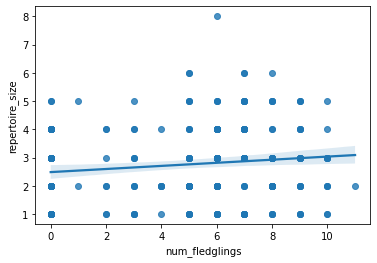

In [90]:
# get kn(spatial)n


k = 5
year = 2020
coordata = bird_data.query(
    "year==@year and repertoire_size == repertoire_size"
)[["x", "y"]]

tree = BallTree(coordata.values, metric="euclidean")
distances, indices = tree.query(coordata.values, k=k + 1)
coordata["spatial_nn"] = [coordata.index[i].values[1:] for i in indices]

labs_dict = {pnum: [l for l in labs if pnum in l] for pnum in coordata.index}


# calculate acoustic neigbours for this year only

# Add labels and calculate class means
metric = "cosine"
feat_vec.index = labels
feat_vec_year = feat_vec[feat_vec.index.str.contains(str(year))]
vecdf = feat_vec_year.groupby(feat_vec_year.index).mean()

vecmed = vecdf.to_numpy()
sim_mat = pairwise_distances(vecmed, metric=metric)
mx = 1 - sim_mat
mx = np.round((mx - np.min(mx)) / np.ptp(mx), 5)

# Get k nearest acoustic neighbours for each bird

# nn queries
indx, dists = nnindex.query(mx, k=4)
indx = indx[:, 1:]
dists = dists[:, 1:]

kk = []
for pnum in with_pbar(coordata.index):
    l = labs_dict[pnum]
    nl = len(l)

    for query in l:
        loc = np.where(labs == query)[0][0]
        distances, neighbours = dists[loc], labs[indx[loc]]

    kk.append([pnum, neighbours])


for pnum in with_pbar(coordata.index):
    coordata.loc[pnum, "spatial_nn"]
    labs_dict[pnum]
    for query in labs_dict[pnum]:
        loc = np.where(labs == query)[0][0]
        distances, neighbours = dists[loc], labs[indx[loc]]


for name, d, ind in zip(coordata.index, distances, indices):
    print(f"NAME {name} closest matches:")
    for i, index in enumerate(ind):
        print(f"\t{bird_data.index[index]} with distance {d[i]} m")


bird_data.query("pnum == '20211O115'")

In [199]:
# Similarity with natal vs territory neighbours

# Similarity with own year vs previous year males

# Mean similarity with neighbours for resident and immigrants

# mean similarity between own songs vs random set of equal size from rest of the population

# delete members of own class (also works on full matrix)
knnidx = []
knndists = []
for i, d, l in zip(idx, dists, labels):
    rmidx = np.where(np.array(labels) == l)[0]
    idxs = np.isin(i, rmidx)
    knnidx.append(np.delete(i, idxs, axis=0))
    knndists.append(np.delete(d, idxs, axis=0))

class_medians = np.median(dists, axis=1)
mindist = np.argmin(class_medians)
maxdist = np.argmax(class_medians)

ulabs = list(dict.fromkeys(labels))
print(f"{ulabs[mindist] = }, {ulabs[maxdist] = }")

groups = (
    pd.Series(range(len(median_dst)))
    .groupby(labels, sort=False)
    .apply(list)
    .tolist()
)
class_mx = [np.mean([median_dst[i] for i in idx]) for idx in groups]

diag = pd.Series(
    np.diag(class_dist_mat),
    index=[class_dist_mat.index, class_dist_mat.columns],
)


mx


l = "B227_1"
rmidx = np.where(np.array(labels) == l)[0]
index.query(mx[rmidx], k=10)


# NOTE: array will be irregular if not all own labels
# are among the knn

median_dst = [np.median(i) for i in knndists]
groups = (
    pd.Series(range(len(median_dst)))
    .groupby(labels, sort=False)
    .apply(list)
    .tolist()
)
class_medians = [np.median([median_dst[i] for i in idx]) for idx in groups]

mindist = np.argmin(class_medians)
maxdist = np.argmax(class_medians)

ulabs = list(dict.fromkeys(labels))
print(f"{ulabs[mindist] = }, {ulabs[maxdist] = }")


class_medians[mindist]
class_medians[maxdist]

sim_mat_class = pd.DataFrame(mx, columns=labels, index=labels)

sim_mat.index.values[mindist]
sim_mat.index.values[maxdist]


labels[mindist]
labels[maxdist]

median_dst[mindist]
median_dst[maxdist]

NameError: name 'df' is not defined